In [1]:
import os
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import re
import collections
import string
import math
%matplotlib inline

In [2]:
filename = './data/train.csv'
train_data_ = pd.read_csv(filename)
train_data_.head()

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [3]:
filename = './data/impermium_verification_labels.csv'
test_data_ = pd.read_csv(filename)
test_data_.head()

,id,Insult,Date,Comment,Usage
0,1,0,20120603163526Z,"""like this if you are a tribe fan""",PrivateTest
1,2,1,20120531215447Z,"""you're idiot.......................""",PrivateTest
2,3,1,20120823164228Z,"""I am a woman Babs, and the only ""war on women...",PrivateTest
3,4,1,20120826010752Z,"""WOW & YOU BENEFITTED SO MANY WINS THIS YEAR F...",PrivateTest
4,5,1,20120602223825Z,"""haha green me red you now loser whos winning ...",PrivateTest


In [4]:
test_data_ = test_data_.drop('id', axis=1)
test_data_ = test_data_.drop('Usage', axis=1)
test_data_.head()

,Insult,Date,Comment
0,0,20120603163526Z,"""like this if you are a tribe fan"""
1,1,20120531215447Z,"""you're idiot......................."""
2,1,20120823164228Z,"""I am a woman Babs, and the only ""war on women..."
3,1,20120826010752Z,"""WOW & YOU BENEFITTED SO MANY WINS THIS YEAR F..."
4,1,20120602223825Z,"""haha green me red you now loser whos winning ..."


In [5]:
filename = './data/test_with_solutions.csv'
valid_data_ = pd.read_csv(filename)
valid_data_.head()

,Insult,Date,Comment,Usage
0,0,NaN,"""THE DRUDGE REPORT\\n\\n\\n\\nYou won't see th...",PublicTest
1,0,20120618222256Z,"""@ian21\xa0""Roger Clemens is the fucking man, ...",PublicTest
2,1,20120618213617Z,"""Agree with Alan you are an extremest idiot. ...",PublicTest
3,0,NaN,"""Really?\\n\\nI see Marc Lamont Hill on variou...",PrivateTest
4,0,20120620003825Z,"""Really suck isn't the word, when many of our ...",PrivateTest


In [7]:
def data_preprocessing(data):
    max_sym_len = 0
    max_word_len = 0
    lens_in_words = []

    for i, comment in enumerate(data.iloc[:,2]):
        data.iloc[i,2] = data.iloc[i,2].lower()
        data.iloc[i,2] = re.sub('n\'t', ' not', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'m', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'s', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'re', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'ve', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'d', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub(' im ', ' i', data.iloc[i,2])
        data.iloc[i,2] = re.sub(' ur ', ' you ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\? ', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('[!?]+', ' mysignssymbol ', data.iloc[i,2])
        data.iloc[i,2] = re.sub(r'href=[\'"]?([^\'" >]+)', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('[^a-z]+', ' ', data.iloc[i,2]) # replace everything not lowercase literals with space
        data.iloc[i,2] = re.sub('\s+', ' ',  data.iloc[i,2] ).strip() #replace multiple spaces
        for letter in string.ascii_lowercase: #replace multiple letters (3 and more) 
            data.iloc[i,2] = re.sub(letter * 3 + '+', letter,  data.iloc[i,2] ).strip() 
        data.iloc[i,2] = re.sub('mysignssymbol', '<SIGNS>', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\s+', ' ',  data.iloc[i,2] ).strip() #replace multiple spaces
        if max_sym_len < len(comment):
            max_sym_len = len(comment)
        if max_word_len < len(comment.split(' ')):
            max_word_len = len(comment.split(' '))
        lens_in_words.append(len(comment.split(' ')))
        if (i % 1000) == 0:
            print ('Step: %d\n' % i)
        
    print ('Max comment length in symbols:', max_sym_len)
    print ('Max comment length in words:  ', max_word_len)
    plt.plot(np.arange(len(lens_in_words)), np.asarray(lens_in_words))
    plt.xlabel('Comment')
    plt.ylabel('Length in words')
    return data

Step: 0

Step: 1000

Step: 2000

Max comment length in symbols: 1437
Max comment length in words:   224


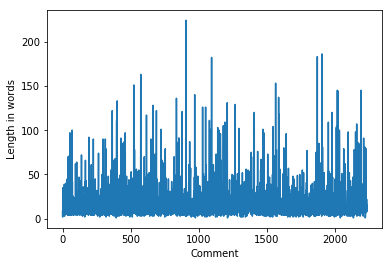

In [9]:
#train_data = data_preprocessing(train_data_)
test_data = data_preprocessing(test_data_)
#valid_data = data_preprocessing(valid_data_)

In [10]:
#train_data.to_csv('./data/prepr_train.csv', index=False)
#valid_data.to_csv('./data/prepr_valid.csv', index=False)
test_data.to_csv('./data/prepr_test.csv', index=False)

### For fasttext input

In [13]:
def write_input_file_fasttext(data, name):
    f = open(name + '.txt', 'w')
    for i in range(data.shape[0]):
        if name == 'train' or name == 'valid' or name == 'test':
            f.write('__label__' + str(data.iloc[i,0]) + " " +  data.iloc[i,2] + '\n')
        #elif name == 'test':
        #    f.write(data.iloc[i,2] + '\n')
        else:
            print ('Incorrect data name')
    f.close()

In [14]:
#write_input_file_fasttext(train_data, name='train')
#write_input_file_fasttext(valid_data, name='valid')
write_input_file_fasttext(test_data, name='test')

### Wikipedia talk

In [9]:
filename = './data/wikipedia_talk_personal_attacks/attack_annotated_comments.tsv'
comments = pd.read_csv(filename, sep = '\t', index_col = 0)
comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


In [10]:
filename = './data/wikipedia_talk_personal_attacks/attack_annotations.tsv'
annotations = pd.read_csv(filename,  sep = '\t')
annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


In [11]:
print ('Number of comments:', len(annotations['rev_id'].unique()))

Number of comments: 115864


In [12]:
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [13]:
comments['attack'] = labels

In [14]:
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [15]:
comments.head()

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,`- This is not ``creative``. Those are the di...,2002,False,article,random,train,False
44816,` :: the term ``standard model`` is itself le...,2002,False,article,random,train,False
49851,"True or false, the situation as of March 200...",2002,False,article,random,train,False
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,False
93890,This page will need disambiguation.,2002,True,article,random,train,False


In [16]:
comments.rename(columns={'comment': 'Comment', 'attack': 'Insult', 'year': 'Date'}, inplace=True)

In [17]:
comments.head()

,Comment,Date,logged_in,ns,sample,split,Insult
rev_id,,,,,,,
37675,`- This is not ``creative``. Those are the di...,2002,False,article,random,train,False
44816,` :: the term ``standard model`` is itself le...,2002,False,article,random,train,False
49851,"True or false, the situation as of March 200...",2002,False,article,random,train,False
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,False
93890,This page will need disambiguation.,2002,True,article,random,train,False


In [18]:
comments_ = comments.loc[:,['Insult','Date','Comment']]

In [19]:
comments_.head()

,Insult,Date,Comment
rev_id,,,
37675,False,2002,`- This is not ``creative``. Those are the di...
44816,False,2002,` :: the term ``standard model`` is itself le...
49851,False,2002,"True or false, the situation as of March 200..."
89320,False,2002,"Next, maybe you could work on being less cond..."
93890,False,2002,This page will need disambiguation.


In [20]:
full_train_data_ = train_data.append(comments_, ignore_index=True)

In [21]:
full_train_data_.head()

,Insult,Date,Comment
0,1,20120618192155Z,you fuck your dad
1,0,20120528192215Z,i really do not understand your point xa it se...
2,0,NaN,a xc xa majority of canadians can and has been...
3,0,NaN,listen if you dont wanna get married to a man ...
4,0,20120619094753Z,c xe c b u ea n xu u ed ng u u b u eddng bi u ...


Step: 0

Step: 100

Step: 200

Step: 300

Step: 400

Step: 500

Step: 600

Step: 700

Step: 800

Step: 900

Step: 1000

Step: 1100

Step: 1200

Step: 1300

Step: 1400

Step: 1500

Step: 1600

Step: 1700

Step: 1800

Step: 1900

Step: 2000

Step: 2100

Step: 2200

Step: 2300

Step: 2400

Step: 2500

Step: 2600

Step: 2700

Step: 2800

Step: 2900

Step: 3000

Step: 3100

Step: 3200

Step: 3300

Step: 3400

Step: 3500

Step: 3600

Step: 3700

Step: 3800

Step: 3900

Step: 4000

Step: 4100

Step: 4200

Step: 4300

Step: 4400

Step: 4500

Step: 4600

Step: 4700

Step: 4800

Step: 4900

Step: 5000

Step: 5100

Step: 5200

Step: 5300

Step: 5400

Step: 5500

Step: 5600

Step: 5700

Step: 5800

Step: 5900

Step: 6000

Step: 6100

Step: 6200

Step: 6300

Step: 6400

Step: 6500

Step: 6600

Step: 6700

Step: 6800

Step: 6900

Step: 7000

Step: 7100

Step: 7200

Step: 7300

Step: 7400

Step: 7500

Step: 7600

Step: 7700

Step: 7800

Step: 7900

Step: 8000

Step: 8100

Step: 8200

Step: 8300

Step

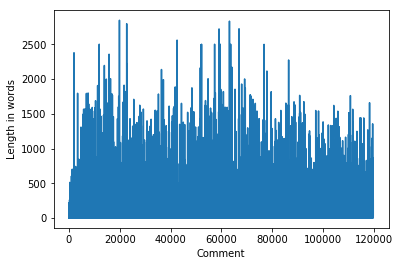

In [22]:
full_train_data = data_preprocessing(full_train_data_)

In [23]:
full_train_data.to_csv('./data/prepr_full_train.csv', index=False)

In [24]:
full_train_data.head()

,Insult,Date,Comment
0,1,20120618192155Z,you fuck your dad
1,0,20120528192215Z,i really do not understand your point xa it se...
2,0,NaN,a xc xa majority of canadians can and has been...
3,0,NaN,listen if you dont wanna get married to a man ...
4,0,20120619094753Z,c xe c b u ea n xu u ed ng u u b u eddng bi u ...
